# Wraggling, Summarizing, and Plotting 

## Preliminaries

You don't need to import numpy to run pandas, but numpy comes in handy so often, we generally import it as well.

In [1]:
import numpy as np
import pandas as pd

Let's re-use our function to load and clean up data from last time (but with a new name).

In [2]:
def bcd_load_clean():
    bcd = pd.read_csv('./data/breast_cancer_data.csv')
    bcd['patient_id'] = bcd['patient_id'].astype('string')
    bcd['doctor_name'] = bcd['doctor_name'].str.split().str[1]
    bcd['bare_nuclei'] = bcd['bare_nuclei'].replace('?', '')
    bcd['bare_nuclei'] = pd.to_numeric(bcd['bare_nuclei'])
    
    return bcd

---

Load our data:

In [3]:
bcd = bcd_load_clean()

---

Now, for convenience, let's make a smaller data set to play with. We'll do this by dropping some of the columns.

We can do this in one of two ways. We can either `.drop` the columns we don't want, or `.copy` the columns we do. Here's the first method:

In [4]:
bcd2 = bcd.drop(labels = ['patient_id', 'cell_size_uniformity', 'cell_shape_uniformity', 
                          'cell_shape_uniformity', 'marginal_adhesion', 'single_ep_cell_size',
                          'bare_nuclei', 'normal_nucleoli', 'mitoses'],
                axis = 1,             # we're selecting column - default is rows
                inplace = False)      # we could modify bcd itself with True

In [5]:
bcd2

,clump_thickness,bland_chromatin,class,doctor_name
0,5.0,3.0,benign,Doe
1,5.0,3.0,benign,Smith
2,3.0,3.0,benign,Lee
3,6.0,3.0,benign,Smith
4,4.0,3.0,benign,Wong
...,...,...,...,...
694,3.0,1.0,benign,Lee
695,2.0,1.0,benign,Smith
696,5.0,8.0,malignant,Lee
697,4.0,10.0,malignant,Lee


---

In the cell below, make the same new data frame using column indexing and the `.copy()` method.

In [6]:
bcd2 = bcd[['clump_thickness','bland_chromatin','class','doctor_name']].copy()

In [7]:
bcd2

,clump_thickness,bland_chromatin,class,doctor_name
0,5.0,3.0,benign,Doe
1,5.0,3.0,benign,Smith
2,3.0,3.0,benign,Lee
3,6.0,3.0,benign,Smith
4,4.0,3.0,benign,Wong
...,...,...,...,...
694,3.0,1.0,benign,Lee
695,2.0,1.0,benign,Smith
696,5.0,8.0,malignant,Lee
697,4.0,10.0,malignant,Lee


---

## What might we want from this data set?

The main thing that comes to mind is whether any of the measures are related to the kind of tumor. To do this, we can

- group the data by the "class" column
- perform some operation, like computing the mean, separately for the groups.

We might also want to see if the doctors are behaving consistently with respect to one another.

### The split-apply-combine workflow

Much of data wrangling can be thought of "split-apply-combine". This is where we

- *split* the data into groups
- do ("*apply*") some function or manipulation on a per-group basis
- *combine* the results back into a data frame, series, etc.

Happily, the "combine" step is often handled for you by the methods that do the "apply" step.

#### Splitting - the `groupby()` method

Grouping the data is easy using the `groupby()` method. We just provide the name of a grouping variable. Since the main question at hand is how the measurements might relate to the type of tumor, Let's group by tumor "class".

In [8]:
grpd = bcd2.groupby('class')

If we try to look at it:

In [9]:
grpd

we see that the output of '.groupby() isn't a regular data frame, but rather a `DataFrameGroupBy` object. To interegate it, well need to use its methods or look at its attributes.

---

In the cell below, use the \<TAB\> key trick to browse the methods and properties that `grpd` has.

In [10]:
grpd.

SyntaxError: invalid syntax (1579351624.py, line 1)

---

One of the early methods on the list is `.boxplot` - see what that does in the cell below!

benign            AxesSubplot(0.1,0.15;0.363636x0.75)
malignant    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

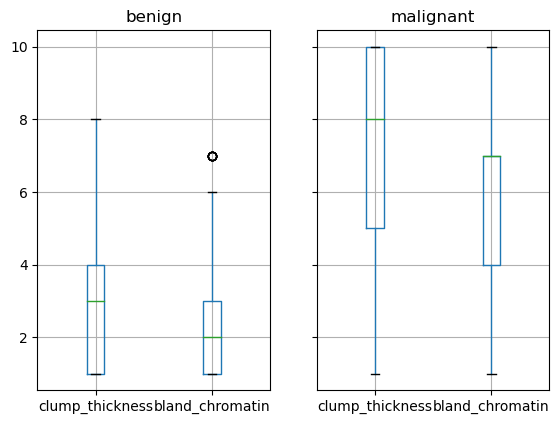

In [11]:
grpd.boxplot()

While not the prettiest plot in the world, it does give us a hint that both of these variables might be related to tumor size.

(Make sure you remember or remind yourself what a box shows you.)

---

Now let's see if we can `.describe` the grouped data using the cell below.

In [12]:
grpd.describe()

clump_thickness                                                 \
                    count      mean       std  min  25%  50%   75%   max   
class                                                                      
benign              458.0  2.956332  1.674318  1.0  1.0  3.0   4.0   8.0   
malignant           240.0  7.204167  2.429763  1.0  5.0  8.0  10.0  10.0   

          bland_chromatin                                                
                    count      mean       std  min  25%  50%  75%   max  
class                                                                    
benign              455.0  2.105495  1.081417  1.0  1.0  2.0  3.0   7.0  
malignant           240.0  5.991667  2.270406  1.0  4.0  7.0  7.0  10.0

---

What is the approximate mean difference between the groups for each of the two measures?

For clump thickness the approximate difference is around 4.25 and for bland chromatin 3.89.

---

Do a very rough guesstimate of Student's *t* for the clump thickness (e.g., just use the larger `std` and smaller `countn`). You can use the cell below as a calculator if you like. 

In [13]:
7.204167/(2.429763/(240*(1/2)))

355.79603442804915

What does that tell you?

---

Now let's make a histogram of grouped data using the appropriate method.

class
benign       [[AxesSubplot(0.125,0.11;0.336957x0.77), AxesS...
malignant    [[AxesSubplot(0.125,0.11;0.336957x0.77), AxesS...
dtype: object

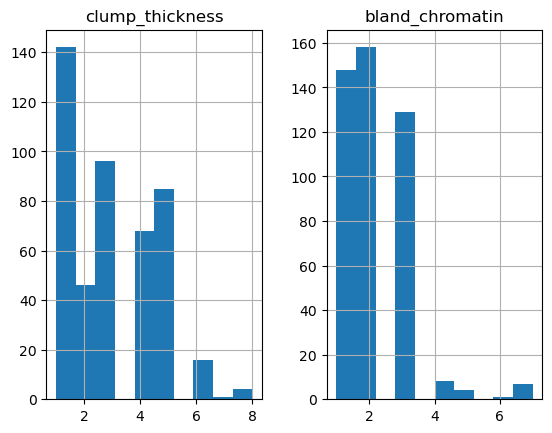

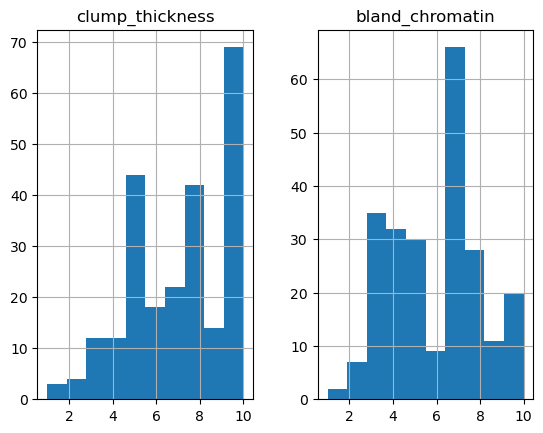

In [14]:
grpd.hist()

Again, not the prettiest plot in the world. By comparison with the boxplot above, we can see that the top row of these histograms correspond to the benign tumors. We can also see that, consistent with the box plots, there is quite a bit overlap in the data values across groups. Is this consistent with your calculation of *t*?

---

We can also get the data for a specific group out of the grouped object. This will return a regular data frame the same width as the original, but only containing the requested group's data.

In [15]:
grpd.get_group('benign')

,clump_thickness,bland_chromatin,class,doctor_name
0,5.0,3.0,benign,Doe
1,5.0,3.0,benign,Smith
2,3.0,3.0,benign,Lee
3,6.0,3.0,benign,Smith
4,4.0,3.0,benign,Wong
...,...,...,...,...
690,1.0,1.0,benign,Doe
692,3.0,1.0,benign,Wong
693,3.0,2.0,benign,Lee
694,3.0,1.0,benign,Lee


---

In the cell below, confirm that the returned object is indeed a pandas `DataFrame`.

In [16]:
benign_df = pd.DataFrame(grpd.get_group('benign'))
benign_df

,clump_thickness,bland_chromatin,class,doctor_name
0,5.0,3.0,benign,Doe
1,5.0,3.0,benign,Smith
2,3.0,3.0,benign,Lee
3,6.0,3.0,benign,Smith
4,4.0,3.0,benign,Wong
...,...,...,...,...
690,1.0,1.0,benign,Doe
692,3.0,1.0,benign,Wong
693,3.0,2.0,benign,Lee
694,3.0,1.0,benign,Lee


---

#### Applying - doing things to the data within groups

Once we have grouped data, we can easily caluculate things per group. Using the \<TAB\> trick, we can see that these objects produced by `groupby()` have methods for all the common statistical summaries.

##### *Simple calculations*

We can compute the mean for each measure *by group*

In [17]:
my_means = grpd.mean(numeric_only = True)
my_means

,clump_thickness,bland_chromatin
class,,
benign,2.956332,2.105495
malignant,7.204167,5.991667


---

In the cells below, compute and show the

standard deviations:

In [18]:
my_sds =  grpd.std()
my_sds

,clump_thickness,bland_chromatin
class,,
benign,1.674318,1.081417
malignant,2.429763,2.270406


and the counts

In [19]:
my_count = grpd.count()
my_count

,clump_thickness,bland_chromatin,doctor_name
class,,,
benign,458,455,458
malignant,240,240,241


---

We can easily do simple maths on data frames of a compatible size. Here's a comparison of how many z-scores above zero each of the means are:

In [20]:
my_zeds = my_means/my_sds
my_zeds

,clump_thickness,bland_chromatin
class,,
benign,1.765693,1.946977
malignant,2.964967,2.639029


We can look at the difference between the z-scores for each measure using the `diff()` method, which takes the first difference down the rows.

In [21]:
my_zeds.diff()

,clump_thickness,bland_chromatin
class,,
benign,NaN,NaN
malignant,1.199274,0.692052


This difference in z-scores – how far apart two means are in terms of the standard deviation of the data – is roughly what statisticians call "effect size".

---

Why do the NaNs appear in the first row?

Because the malignant rows are showing the difference between malignant and benign, the top row is not needed. 

In the cell below, extract just the row with the numbers from `my_zeds` into a new series. (hint: using `.loc` is probably easiest)

In [22]:
my_zeds.loc['benign']

clump_thickness    1.765693
bland_chromatin    1.946977
Name: benign, dtype: float64

---

We could also compute the difference by using `.loc[]` row indexing and simple maths.

In [23]:
my_zeds.loc['malignant'] - my_zeds.loc['benign']

clump_thickness    1.199274
bland_chromatin    0.692052
dtype: float64

##### *Mulitiple caclulations with* `agg()`

We can do multiple calculation at once by placing function names inside the `agg()` ) or `aggregate()`) methods (they are synonyms). Here's where importing numpy comes in handy.

In [24]:
grpd.agg([np.mean, np.std])

/var/folders/zc/6v283x0929j5f38j6cvlvbwr0000gn/T/ipykernel_8279/1757925766.py:1: FutureWarning: ['doctor_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  grpd.agg([np.mean, np.std])


clump_thickness           bland_chromatin          
                     mean       std            mean       std
class                                                        
benign           2.956332  1.674318        2.105495  1.081417
malignant        7.204167  2.429763        5.991667  2.270406

That worked,  but pandas still complained to us because `grpd` has the doctors' names in it, and we obviously can't compute the means and standard deviations of those!

---

In the cell below, repeat the above calculation without triggering the warning.

In [25]:
bcd_num = bcd[['clump_thickness','bland_chromatin','class']].copy()
grpd_num = bcd_num.groupby('class')
grpd_num.agg([np.mean,np.std])

clump_thickness           bland_chromatin          
                     mean       std            mean       std
class                                                        
benign           2.956332  1.674318        2.105495  1.081417
malignant        7.204167  2.429763        5.991667  2.270406

---

We can use the pandas versions of functions by placing them in quotes. This is handy because, for example, pandas has a `count` and numpy doesn't.

In [26]:
grpd[['clump_thickness', 'bland_chromatin']].agg([np.mean, 'std', 'count'])

clump_thickness                 bland_chromatin                
                     mean       std count            mean       std count
class                                                                    
benign           2.956332  1.674318   458        2.105495  1.081417   455
malignant        7.204167  2.429763   240        5.991667  2.270406   240

#### MultiIndexing - getting at our summary data

Let's store our summary table little summary table above in its own data frame. This is going to complete our *split-apply-combine* by creating and naming a `DataFrame` object.

In [27]:
my_summary = grpd[['clump_thickness', 'bland_chromatin']].agg([np.mean, 'std', 'count'])
my_summary

clump_thickness                 bland_chromatin                
                     mean       std count            mean       std count
class                                                                    
benign           2.956332  1.674318   458        2.105495  1.081417   455
malignant        7.204167  2.429763   240        5.991667  2.270406   240

Notice that this data frame has hierachical column labels. In other words, there is a "clump_thickness" meta-column that contains three colums of its own, and that these subcolumns have the same names as those in the other meta-column. Thus saying "look at the mean column" would be ambiguous because the meta-column wasn't specified.

In pandas, this is known at "multiIndexing". 

Getting a meta-column is easy - it's just like getting a regular column from a data frame.

In [28]:
my_summary['clump_thickness']

,mean,std,count
class,,,
benign,2.956332,1.674318,458
malignant,7.204167,2.429763,240


To get a subcolumn, we can index the meta-column, and then index the subcolumn from that.

In [29]:
my_summary['clump_thickness']['mean']

class
benign       2.956332
malignant    7.204167
Name: mean, dtype: float64

If this looks confusing, consider the same thing broken up into two steps:

In [30]:
meta_c = my_summary['clump_thickness']
meta_c

,mean,std,count
class,,,
benign,2.956332,1.674318,458
malignant,7.204167,2.429763,240


In [31]:
meta_c['mean']

class
benign       2.956332
malignant    7.204167
Name: mean, dtype: float64

---

In the cell below, extract the mean and std of "bland_chromatin" in one go.

In [32]:
my_summary['bland_chromatin'][['mean','std']]

,mean,std
class,,
benign,2.105495,1.081417
malignant,5.991667,2.270406


---

If we want values from a row, we need to get a bit more fancy and use `.loc`.

We can get a whole row using `df.loc[row_index(s)]`

In [33]:
my_summary.loc['benign']

clump_thickness  mean       2.956332
                 std        1.674318
                 count    458.000000
bland_chromatin  mean       2.105495
                 std        1.081417
                 count    455.000000
Name: benign, dtype: float64

(note: that this gave us a hierarchical index!)

We can get a row and and a particular column with 
`df.loc[row_index(s),  (metacolumn_index, subcolumn_index)]`

In [34]:
my_summary.loc['benign', ('clump_thickness', 'mean')]

2.9563318777292578

We can also get bigger slices of the data with the colon `:` operator:

In [35]:
my_summary.loc['benign', ('clump_thickness', 'mean'):('bland_chromatin', 'std')]

clump_thickness  mean       2.956332
                 std        1.674318
                 count    458.000000
bland_chromatin  mean       2.105495
                 std        1.081417
Name: benign, dtype: float64

---

In the cell below, extract the mean and std of the bland chromatin meta-column.

In [36]:
my_summary.loc[('benign','malignant'), ('bland_chromatin', 'mean'):('bland_chromatin', 'std')]

bland_chromatin          
                     mean       std
class                              
benign           2.105495  1.081417
malignant        5.991667  2.270406

---

#### Simple caculations with pivot tables

Pivot tables are summary data with the levels of one variable running down the row names (the index), the levels of another running across the column names, and values populating the interior. This should be made concrete by making one with the `pivot_table()` method:

In [37]:
bcd2.pivot_table(index = 'doctor_name', columns = 'class', values = 'bland_chromatin')

class,benign,malignant
doctor_name,,
Doe,2.000000,5.456140
Lee,2.067227,6.150000
Smith,1.980392,6.459459
Wong,2.388889,5.714286


By default, `pivot_table()` computes the group (row x column) means, but we can compute any of the standard summary statistics we wish. We just specify it using the `aggfunc` argument:

In [38]:
bcd2.pivot_table(index = 'doctor_name', 
                 columns = 'class', 
                 values = 'bland_chromatin', 
                 aggfunc = 'std')

class,benign,malignant
doctor_name,,
Doe,1.003992,2.260453
Lee,1.014564,2.121920
Smith,0.943769,2.330202
Wong,1.303004,2.263846


These are called "pivot tables" because their implementation makes it easy to pivot our view of the data summary.

---

In the cell below, "pivot" our view of the means so we have "class" down the rows, doctor name across the columns, and the means of clump thickness inside the table.

In [39]:
bcd2.pivot_table(index = 'class', 
                 columns = 'doctor_name', 
                 values = 'clump_thickness', 
                 aggfunc = 'mean')

doctor_name,Doe,Lee,Smith,Wong
class,,,,
benign,2.637795,2.983471,3.098039,3.166667
malignant,7.586207,6.600000,7.356164,7.265306


---

Because clumb thickness and bland chromatin only have the values 1 to 10, we could use either one as a grouping variable in a pivot table:

In [40]:
bcd2.pivot_table(index = 'clump_thickness', columns = 'class', values = 'bland_chromatin')

class,benign,malignant
clump_thickness,,
1.0,1.978723,5.666667
2.0,2.090909,5.000000
3.0,2.145833,5.500000
4.0,2.117647,7.916667
5.0,2.011765,5.818182
6.0,3.062500,6.666667
7.0,2.000000,5.818182
8.0,3.750000,5.761905
9.0,NaN,5.142857


Notice the NaNs – no benign tumors have a thickness of 9 or 10.

## Grouped plotting

As we have already seen, the seaborn package can take care of grouping for us – we just need to assign a grouping variable to color ('hue'), style, etc. And we already know how to do all this!

In [41]:
import seaborn as sns

---

Make a distribution plot (like a histogram) of bland chromatin values grouped by tumor type.

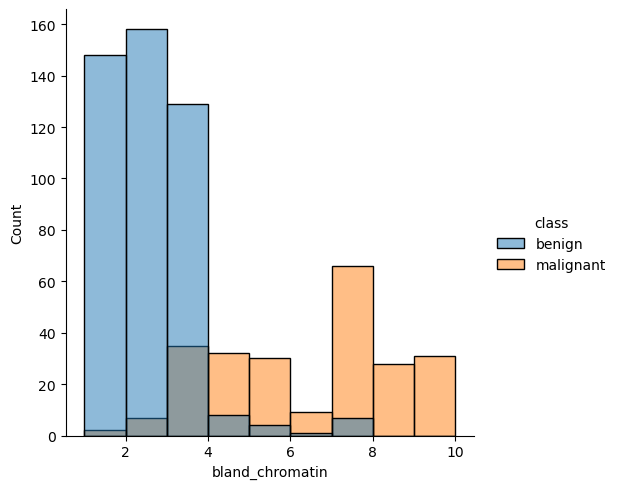

In [42]:
sns.displot(bcd2, x="bland_chromatin", hue = 'class', bins = 9)

---

Make a joint plot grouped by tumor type:

In [44]:
#sns.jointplot(x = 'clump_thickness', y = 'bland_chromatin', hue = 'class')

---

Make a pairplot of our two measurement variables grouped by tumor type.

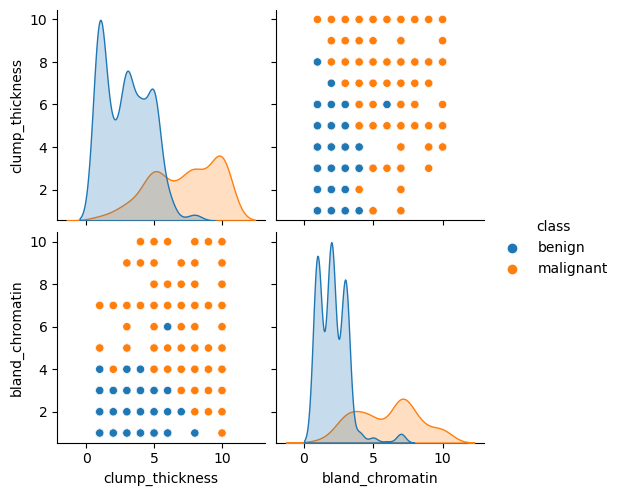

In [45]:
sns.pairplot(bcd2, hue="class")

---

The plot above is okay except for the white space in the diagonal plots that aren't actually missing data. To fix this, we need to set our binwidth to 1, so that it matches the data (which are integers from 1 to 10).

Use the cell below to remake the plot with a binwidth of 1 for the diagonal plot. Hint: use the `plot_kws` argument to adjust this.

AttributeError: 'PathCollection' object has no property 'bins'

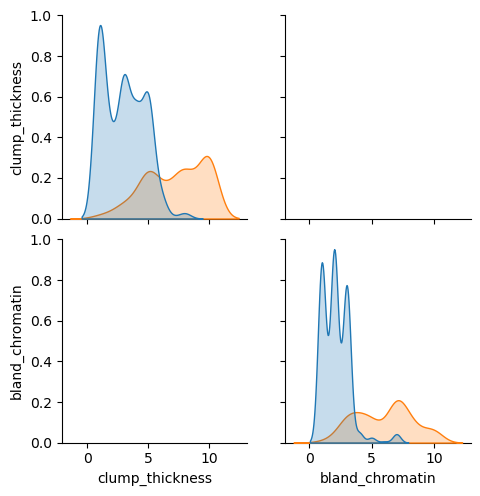

In [46]:
sns.pairplot(bcd2, plot_kws = {'bins':1}, hue = 'class')

---

## Your conclusions

In the cell below, briefly state your conclusions from our analysis above. Are either or both of the measurements related to tumor type?

---

## Summary

In this tutorial, we learned to analyze data by group:

- the split-apply-combine concept
- grouping using `groupby()`
- doing simple grouped calculations 
- doing multiple calculations with `agg()`
- multiIndexing 
- simple summaries with pivot tables